In [51]:
import tensorflow_decision_forests as tfdf
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn.model_selection import train_test_split

%matplotlib inline

print("TensorFlow Decision Forests v" + tfdf.__version__)
print("TensorFlow v" + tf.__version__)

'''
NOTE: 
- protbert finetune - https://www.kaggle.com/code/cdeotte/prot-bert-finetune-lb-0-30/notebook

For each patient visit where a protein/peptide sample was taken you will need to estimate both 
their UPDRS scores for that visit and predict their scores for any potential visits 6, 12, and 24 months later. 
Predictions for any visits that didn't ultimately take place are ignored.

'''

TensorFlow Decision Forests v1.3.0
TensorFlow v2.12.0


'\nNOTE: \n'

# Get Data

In [4]:
train_proteins = pd.read_csv('./data/train_proteins.csv')
train_peptides = pd.read_csv('./data/train_peptides.csv')
train_clinical = pd.read_csv('./data/train_clinical_data.csv')

In [19]:
df_protein_grouped = train_proteins.groupby(['visit_id', 'UniProt'])['NPX'].mean().reset_index()
df_peptide_grouped = train_peptides.groupby(['visit_id', 'Peptide'])['PeptideAbundance'].mean().reset_index()

df_protein = df_protein_grouped.pivot(index='visit_id', columns='UniProt', values='NPX').rename_axis(columns=None).reset_index()
df_peptide = df_peptide_grouped.pivot(index='visit_id', columns='Peptide', values='PeptideAbundance').rename_axis(columns=None).reset_index()

pro_pep_df = df_protein.merge(df_peptide, on='visit_id', how='left')
print(pro_pep_df.shape)
pro_pep_df.head()

(1113, 1196)


,visit_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,O15394,O43505,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,15113.6,167327.0,...,202274.0,NaN,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,NaN,7207.30
1,10053_12,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,15099.1,164268.0,...,201009.0,NaN,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,16289.6,168107.0,...,220728.0,NaN,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,54546.4,204013.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,52338.1,240892.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,NaN,56977.6,4903.09


# Define Model

Random Forests

In [8]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [6]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [10]:
# Train a model for each of the updrs_1-4 labels

model_dict = {}
mse_dict = {}
smape_dict = {}

In [21]:
FEATURES = list(set(pro_pep_df.columns) - set(['visit_id', 'updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']))
FEATURES.append('visit_month')

In [25]:
target = ['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']

for label in target: 
    dataset_df = pro_pep_df.merge(train_clinical[['visit_id', 'patient_id', 'visit_month', label]], on='visit_id', how='left')
    dataset_df = dataset_df.dropna(subset=[label])

    feature_list = FEATURES.copy()
    X = dataset_df[feature_list]
    y = dataset_df[label]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # Concat X and Y
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    # Convert to TF Dataset
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label=label, task=tfdf.keras.Task.REGRESSION)
    test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label=label, task=tfdf.keras.Task.REGRESSION)

    # Build model
    rf = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
    rf.compile(metrics=["mse"])

    # Train + save model
    rf.fit(x=train_ds)
    model_dict[label] = rf

    # Evaluate model
    inspector = rf.make_inspector()
    inspector.evaluation()
    evaluation = rf.evaluate(test_ds, return_dict=True)
    mse_dict[label] = evaluation['mse']

    preds = rf.predict(test_ds)
    smape_dict[label] = smape(y_test.tolist(), preds.flatten())



(854, 1196) (854,) (214, 1196) (214,)


[INFO 23-05-11 21:28:04.0553 CEST kernel.cc:1242] Loading model from path /var/folders/ms/7qgbbtls7n53d594y_8v14140000gn/T/tmp499hd05w/model/ with prefix fdc4e82c9fb2421d
[INFO 23-05-11 21:28:04.1405 CEST decision_forest.cc:660] Model loaded with 300 root(s), 71442 node(s), and 1196 input feature(s).
[INFO 23-05-11 21:28:04.1406 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-11 21:28:04.1409 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 1s 770ms/step
(854, 1196) (854,) (214, 1196) (214,)


[INFO 23-05-11 21:28:19.9758 CEST kernel.cc:1242] Loading model from path /var/folders/ms/7qgbbtls7n53d594y_8v14140000gn/T/tmpk2ocm6k5/model/ with prefix 5f57148016f94b33
[INFO 23-05-11 21:28:20.0578 CEST decision_forest.cc:660] Model loaded with 300 root(s), 68698 node(s), and 1196 input feature(s).
[INFO 23-05-11 21:28:20.0579 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-11 21:28:20.0582 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 27.7735


1/1 [==============================] - 1s 773ms/step
(846, 1196) (846,) (212, 1196) (212,)


[INFO 23-05-11 21:28:35.5168 CEST kernel.cc:1242] Loading model from path /var/folders/ms/7qgbbtls7n53d594y_8v14140000gn/T/tmpaktalt7t/model/ with prefix eaf22d10c0654382
[INFO 23-05-11 21:28:35.6064 CEST decision_forest.cc:660] Model loaded with 300 root(s), 73776 node(s), and 1196 input feature(s).
[INFO 23-05-11 21:28:35.6065 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-11 21:28:35.6068 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 1s 768ms/step
(455, 1196) (455,) (114, 1196) (114,)


[INFO 23-05-11 21:28:49.3014 CEST kernel.cc:1242] Loading model from path /var/folders/ms/7qgbbtls7n53d594y_8v14140000gn/T/tmpbofa596v/model/ with prefix 940640f3da414c3a
[INFO 23-05-11 21:28:49.3320 CEST decision_forest.cc:660] Model loaded with 300 root(s), 24766 node(s), and 1194 input feature(s).
[INFO 23-05-11 21:28:49.3321 CEST abstract_model.cc:1312] Engine "RandomForestOptPred" built
[INFO 23-05-11 21:28:49.3324 CEST kernel.cc:1074] Use fast generic engine


1/1 [==============================] - 1s 718ms/step


In [26]:
for name, value in mse_dict.items():
    print(f"{name}: {value}")

print("Average mse: ", np.mean(list(mse_dict.values())))

for name, value in smape_dict.items():
    print(f"{name}: {value}")

print("Average smape: ", np.mean(list(smape_dict.values())))

updrs_1: 19.50889778137207
updrs_2: 27.77353858947754
updrs_3: 194.60964965820312
updrs_4: 7.880036354064941
Average mse:  62.44303059577942
updrs_1: 71.00458632751145
updrs_2: 99.43621327450975
updrs_3: 91.47764241556183
updrs_4: 155.93035587758706
Average smape:  104.46219947379254


In [43]:
tfdf.model_plotter.plot_model_in_colab(model_dict['updrs_1'], tree_idx=0, max_depth=3)

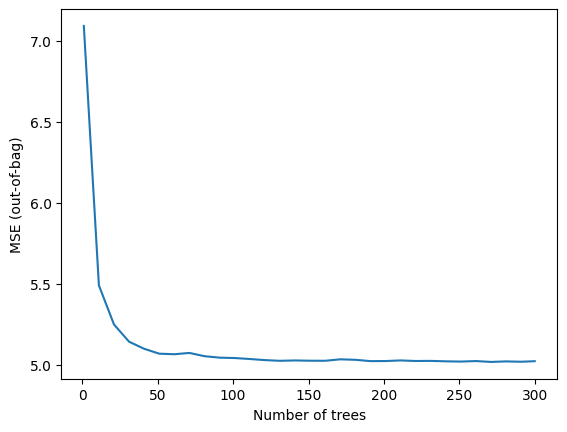

In [44]:
logs = model_dict['updrs_1'].make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("MSE (out-of-bag)")
plt.show()

In [45]:
# Let us use the model for the label `updrs_1` for this purpose
inspector = model_dict['updrs_1'].make_inspector()

print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 NUM_AS_ROOT
	 SUM_SCORE
	 NUM_NODES


In [47]:
inspector.variable_importances()['NUM_AS_ROOT']

[("Q06481" (1; #810), 30.0),
 ("QQTHMLDVMQDHFSR" (1; #888), 25.0),
 ("P04180" (1; #703), 20.0),
 ("P61916" (1; #801), 18.0),
 ("NLREGTC(UniMod_4)PEAPTDEC(UniMod_4)KPVK" (1; #609), 17.0),
 ("NVVYTC(UniMod_4)NEGYSLIGNPVAR" (1; #627), 16.0),
 ("FFLC(UniMod_4)QVAGDAK" (1; #230), 10.0),
 ("VAVVQYSGTGQQRPER" (1; #1082), 9.0),
 ("NILTSNNIDVK" (1; #601), 7.0),
 ("RPGGEPSPEGTTGQSYNQYSQR" (1; #912), 7.0),
 ("O15240" (1; #635), 5.0),
 ("GEAGAPGEEDIQGPTK" (1; #280), 4.0),
 ("ITTTSPWMFPSR" (1; #398), 4.0),
 ("O14773" (1; #633), 4.0),
 ("P05067" (1; #713), 4.0),
 ("Q6UXB8" (1; #829), 4.0),
 ("SSGLVSNAPGVQIR" (1; #988), 4.0),
 ("AATVGSLAGQPLQER" (1; #5), 3.0),
 ("AVC(UniMod_4)SQEAMTGPC(UniMod_4)R" (1; #80), 3.0),
 ("DSGRDYVSQFEGSALGK" (1; #165), 3.0),
 ("EVNVSPC(UniMod_4)PTQPC(UniMod_4)QLSK" (1; #217), 3.0),
 ("LFGGNFAHQASVAR" (1; #483), 3.0),
 ("O00533" (1; #630), 3.0),
 ("P00736" (1; #645), 3.0),
 ("P05060" (1; #712), 3.0),
 ("VYAC(UniMod_4)EVTHQGLSSPVTK" (1; #1149), 3.0),
 ("AGC(UniMod_4)VAESTAVC(

In [50]:
import amp_pd_peptide_310

ModuleNotFoundError: No module named 'amp_pd_peptide_310'